In [2]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs
from utils import get_firing_field

device = 'cpu'

In [18]:
exp_dir = "../trained_models/baseline0.6/"

num_states = 20

# Test dataset
dset = inputs.Sim1DWalk(num_steps=500, num_states=num_states, left_right_stay_prob=[0.5, 2, 1])
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

retrieval_steps = np.arange(200, 300)

with open(exp_dir + 'net_configs.p', 'rb') as f:
    net_configs = pickle.load(f)
print(net_configs)

# Load that model and test
net = STDP_SR(**net_configs)
net.load_state_dict(torch.load(exp_dir + 'model.pt'))
net.set_num_states(num_states)
outs = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    reset = True if step == 0 else False
    retrieval_mode = step in retrieval_steps
    update = True if not retrieval_mode else False
    gamma = None if not retrieval_mode else 0.95
    with torch.no_grad():
        _, out = net(curr_dg_input, reset=reset, gamma=gamma)
        outs.append(out)
outputs = torch.stack(outs).squeeze()

{'num_states': 2, 'gamma': 0.6, 'ca3_kwargs': {'A_pos_sign': 1, 'A_neg_sign': -1, 'output_params': {'num_iterations': inf, 'input_clamp': inf, 'nonlinearity': None}}}


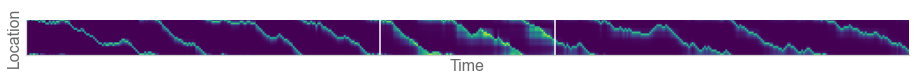

In [53]:
plt.figure(figsize=(13, 7))
plt.axes().set_aspect(10)
plt.imshow(outputs.T, cmap='viridis')
plt.xticks([]); plt.yticks([])
plt.ylabel('Location')
plt.xlabel('Time')
plt.axvline(retrieval_steps[0], color='white')
plt.axvline(retrieval_steps[-1], color='white')
plt.tight_layout()
plt.savefig('2a_learn_retrieve_all.png', dpi=300)
plt.show()

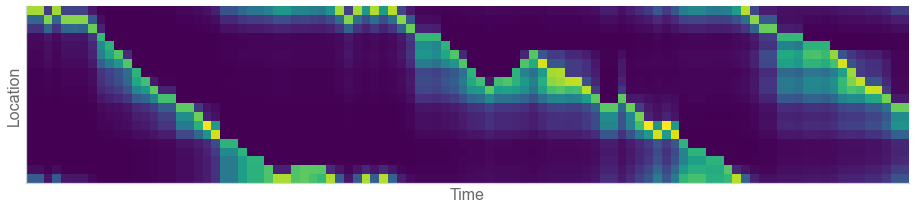

In [54]:
plt.figure(figsize=(13, 7))
plt.axes().set_aspect(10)
plt.imshow(outputs.T[:,retrieval_steps], cmap='viridis')
plt.xticks([]); plt.yticks([])
plt.ylabel('Location')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('2a_learn_retrieve_retphase.png', dpi=300)
plt.show()

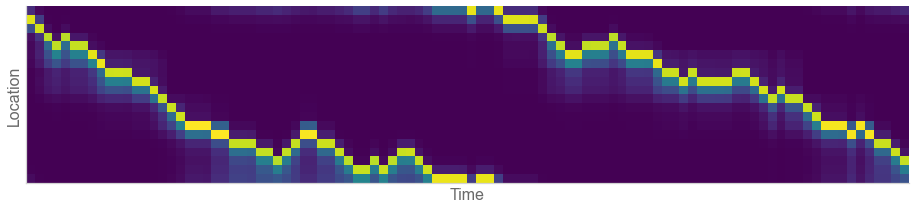

In [55]:
plt.figure(figsize=(13, 7))
plt.axes().set_aspect(10)
plt.imshow(outputs.T[:,-retrieval_steps.size:], cmap='viridis')
plt.xticks([]); plt.yticks([])
plt.ylabel('Location')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('2a_learn_retrieve_lrnphase.png', dpi=300)
plt.show()